In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from statistics import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from imblearn.metrics import sensitivity_specificity_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, MaxPool1D, Input, GlobalAvgPool1D, LSTM
from sklearn.utils.class_weight import compute_class_weight

In [3]:
def get_windows(df, window_size, sampling_frequency, overlap):

    hop_size = window_size - int(sampling_frequency * overlap)
    windows, labels = [], []

    for pos in range(0, len(df) - window_size + 1, hop_size):
        x_i = df.iloc[pos: pos + window_size].drop(columns=['label'])
        l_i = mode(df['label'].iloc[pos: pos + window_size])

        windows.append(x_i.values)
        labels.append(l_i)

    return np.asarray(windows), np.asarray(labels)

In [4]:
def load_and_preprocess_files(file_label_pairs, sampling_frequency, window_size, overlap):
    
    X_combined, Y_combined = [], []

    for file_path, label in file_label_pairs:
        try:
            df = pd.read_csv(file_path, index_col='timestamp')
            # df = df.loc[:, (df != 0.0).any(axis=0)]
            df.dropna(inplace=True)
            df['label'] = label

            X, Y = get_windows(df, window_size, sampling_frequency, overlap)
            if len(X) > 0 and len(Y) > 0:
                X_combined.append(X)
                Y_combined.append(Y)
            else:
                print(f"No valid data windows for file: {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    if not X_combined or not Y_combined:
        print("No valid data processed. Returning empty arrays.")
        return np.empty((0,)), np.empty((0,))

    X_combined = np.vstack(X_combined)
    Y_combined = np.concatenate(Y_combined)
    return X_combined, Y_combined

In [5]:
def build_model(input_shape, output_shape):
    
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(256, kernel_size=5, activation='relu'),
        Dropout(0.1),
        Conv1D(256, kernel_size=5, activation='relu'),
        Dropout(0.2),
        MaxPool1D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(output_shape, activation='softmax')
    ])
    opts = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=opts, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    # model.summary()
    return model

In [6]:
def cm_analysis(y_true, y_pred, labels, title, label_names):

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_perc = cm / cm.sum(axis=1, keepdims=True) * 100

    annot = np.asarray([[f"{p:.1f}%\n{c}" for p, c in zip(row_perc, row)] for row_perc, row in zip(cm_perc, cm)])

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=annot, fmt='', cmap="BuGn", xticklabels=label_names, yticklabels=label_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [7]:
def print_stats(y_pred, y_true):

    sensitivity, specificity, _ = sensitivity_specificity_support(y_true, y_pred, average='weighted')
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    mse = np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

    print(f"Specificity: {specificity:.2f}\n"
          f"Sensitivity: {sensitivity:.2f}\n"
          f"Precision: {precision:.2f}\n"
          f"Recall: {recall:.2f}\n"
          f"F1-score: {f1:.2f}\n"
          f"Accuracy: {accuracy:.2f}\n"
          f"MSE: {mse:.2f}")

In [8]:
def plot_training_history(history):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

Train Data Shape: (3375, 56, 256)
Test Data Shape: (701, 56, 256)
Class weights: {0: 2.1188208616780044, 1: 0.980688497061293, 2: 1.929781082197439}


2025-02-12 21:52:05.632056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-12 21:52:05.632086: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-12 21:52:05.632093: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-12 21:52:05.632109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-12 21:52:05.632118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-02-12 21:52:06.159524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4122 - loss: 1.3896 - val_accuracy: 0.6913 - val_loss: 0.5741
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7642 - loss: 0.6779 - val_accuracy: 0.9245 - val_loss: 0.2433
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9190 - loss: 0.2865 - val_accuracy: 0.9648 - val_loss: 0.1198
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9567 - loss: 0.1542 - val_accuracy: 0.9664 - val_loss: 0.0783
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9670 - loss: 0.1063 - val_accuracy: 0.9799 - val_loss: 0.0575
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9782 - loss: 0.0757 - val_accuracy: 0.9883 - val_loss: 0.0376
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9835 - loss: 0.0527 - val_accuracy: 0.9899 - val_loss: 0.0275
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9872 - loss: 0.0433 - val_accuracy: 0.991

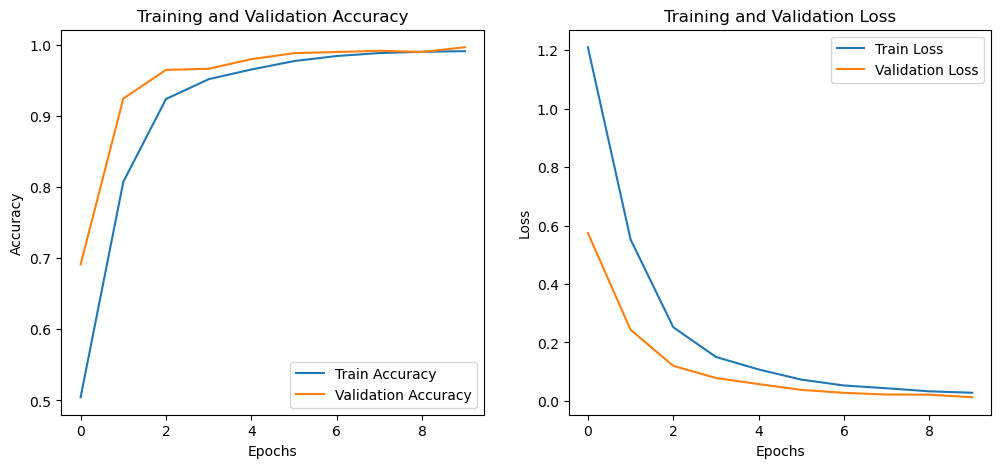

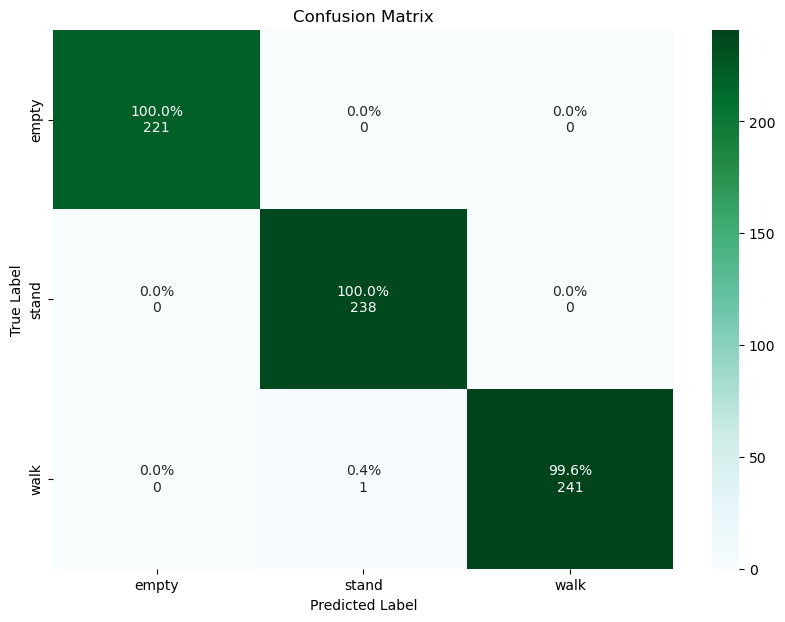

Specificity: 1.00
Sensitivity: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
Accuracy: 1.00
MSE: 0.00


In [ ]:
if __name__ == '__main__':

    seed = 32
    tf.random.set_seed(seed)
    np.random.seed(seed)

    sampling_frequency = 14
    seconds = 4
    window_size = sampling_frequency * seconds
    overlap = 3
    training_epochs = 10
    labels = ['empty', 'stand', 'walk']

    file_directory = '../Data/Dataset/'  
    file_label_mapping = {label: idx for idx, label in enumerate(labels)}

    all_files = []
    for label, label_idx in file_label_mapping.items():
        activity_folder_path = os.path.join(file_directory, label)
        if os.path.exists(activity_folder_path):
            csv_files = [os.path.join(activity_folder_path, file) for file in os.listdir(activity_folder_path) if file.endswith('.csv')]
            all_files.extend([(file, label_idx) for file in csv_files])

    X, Y = load_and_preprocess_files(all_files, sampling_frequency, window_size, overlap)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=seed, stratify=Y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, stratify=y_train)
    print(f"Train Data Shape: {X_train.shape}")
    print(f"Test Data Shape: {X_test.shape}")

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    class_weight_dict[0] *= 2
    class_weight_dict[2] *= 2

    print("Class weights:", class_weight_dict)

    model = build_model(X_train[0].shape, len(labels))
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=training_epochs, batch_size=16, class_weight=class_weight_dict)

    y_pred = model.predict(X_test).argmax(axis=1)


    plot_training_history(history)

    cm_analysis(y_test, y_pred, list(range(len(labels))), "Confusion Matrix", labels)
    print_stats(y_pred, y_test)

    model.save('model.keras')